<a href="https://colab.research.google.com/github/amaricrittenden/amaricrittenden.github.io/blob/main/AMARI_MedicalImaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

In [ ]:

def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)
    
def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)
  
def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data
  
class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)
  
class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry. 
    history = history.history
    history.update({'epoch':list(range(len(history['val_acc'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_acc', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_acc', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'acc', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 

    model.add(Dense(units = 128, activation = 'relu'))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=1e-4, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])    
    return model

  def TransferClassifier(name, nn_params, trainable = False):
    expert_dict = {'VGG16': VGG16, 
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable
      
    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'], 
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters 

### defining project variables
# file variables
image_data_url       = 'https://drive.google.com/uc?id=1DNEiLAWguswhiLXGyVKsgHIRm1xZggt_'
metadata_url         = 'https://drive.google.com/uc?id=1MW3_FU6qc0qT_uG4bzxhtEHy4Jd6dCWb'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
gdown.download(image_data_url, './image_data.npy', True)
gdown.download(metadata_url, './metadata.csv', True)

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:

train_data, train_labels = get_train_data()
test_data, test_labels   = get_test_data()

cnn = CNNClassifier(5)
cnn.fit(train_data, train_labels, epochs = 20)





Epoch 1/20
63/63 [==============================] - 0s 8ms/step - loss: 0.6715 - accuracy: 0.6575
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6036 - accuracy: 0.8025
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 0.4862 - accuracy: 0.8590
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.3794 - accuracy: 0.8730
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.3125 - accuracy: 0.8915
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.2724 - accuracy: 0.8900
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.2417 - accuracy: 0.9125
Epoch 8/20
63/63 [==============================] - 0s 6ms/step - loss: 0.2219 - accuracy: 0.9165
Epoch 9/20
63/63 [==============================] - 0s 6ms/step - loss: 0.1963 - accuracy: 0.9325
Epoch 10/20
63/63 [==============================] - 0s 6ms/step - loss: 0.1776 - accuracy: 0.9395
Epoch 11/20
63/63 [

In [ ]:

field_data, field_labels = get_field_data()


average_accuracy = 0.0 #averaging accuracy with loop
for i in range(5):
  cnn_old = CNNClassifier(5)
  cnn.fit(train_data, train_labels, epochs = 20, validation_data = (test_data, test_labels))



  predictions = cnn.predict_classes(field_data)
  accuracy = accuracy_score(field_labels, predictions)

average_accuracy += accuracy
average_accuracy = average_accuracy / 5.0
print('Average accuracy: ', average_accuracy)




Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 2.1394e-04 - accuracy: 1.0000 - val_loss: 4.1515 - val_accuracy: 0.6850
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 6.0932e-04 - accuracy: 0.9995 - val_loss: 4.2767 - val_accuracy: 0.6800
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2375e-05 - accuracy: 1.0000 - val_loss: 4.5512 - val_accuracy: 0.6700
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 8.8503e-04 - accuracy: 0.9995 - val_loss: 4.3791 - val_accuracy: 0.6775
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 8.6633e-06 - accuracy: 1.0000 - val_loss: 4.5064 - val_accuracy: 0.6700
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.6780e-04 - accuracy: 1.0000 - val_loss: 4.5986 - val_accuracy: 0.6625
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 3.7678e-04 - accuracy: 1.0000 - val_loss: 4.0604 - val_accuracy:

## Error analysis



Label: 0.0


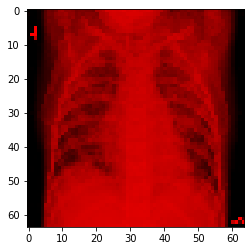

Label: 0.0


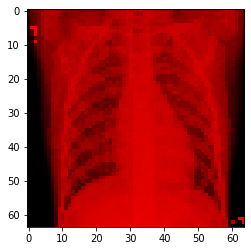

Label: 0.0


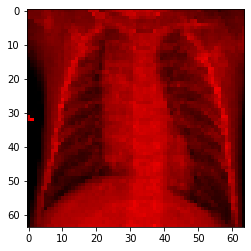

Label: 0.0


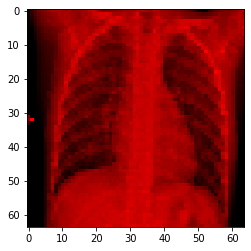

Label: 0.0


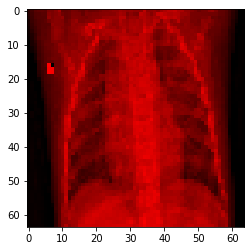

Label: 0.0


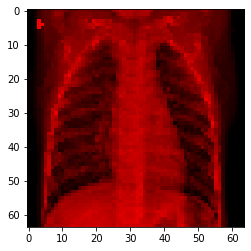

Label: 0.0


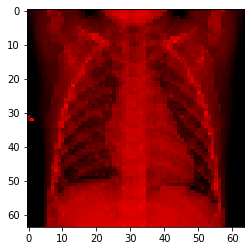

Label: 0.0


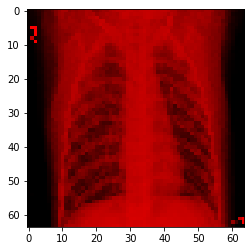

Label: 0.0


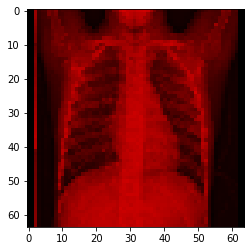

Label: 0.0


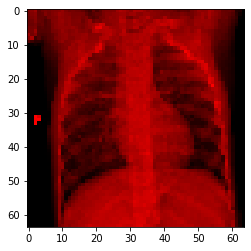

Label: 0.0


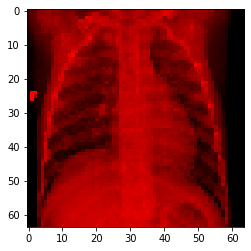

Label: 0.0


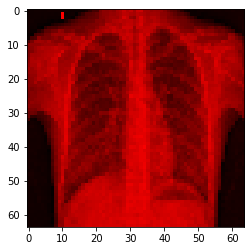

Label: 0.0


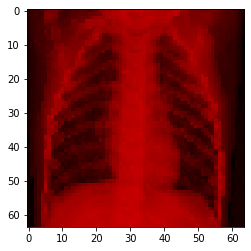

Label: 0.0


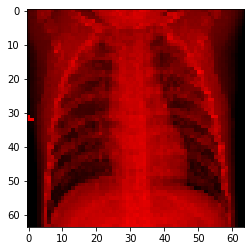

Label: 0.0


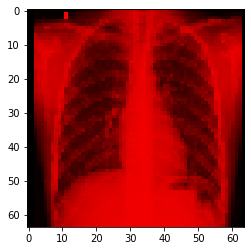

Label: 0.0


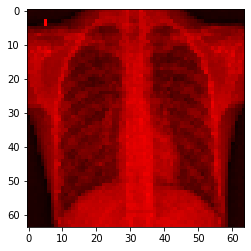

Label: 0.0


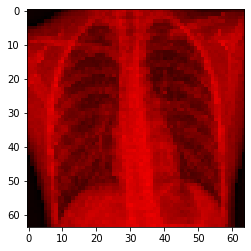

Label: 0.0


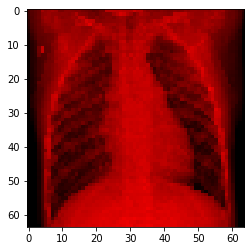

Label: 0.0


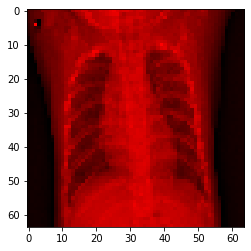

Label: 0.0


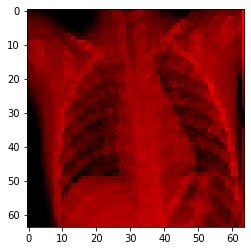

Label: 0.0


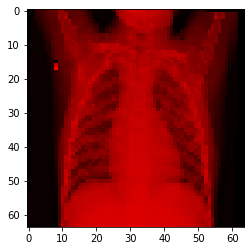

Label: 0.0


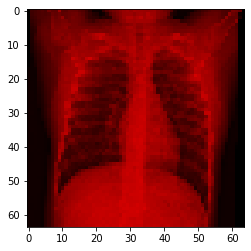

Label: 0.0


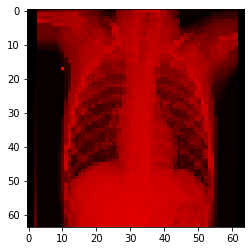

Label: 0.0


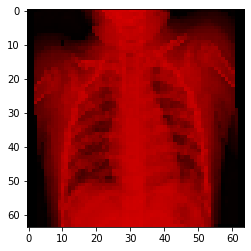

Label: 0.0


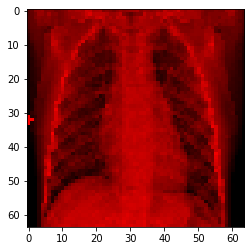

Label: 0.0


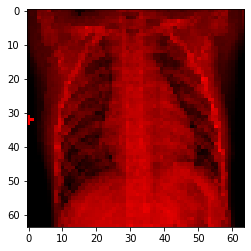

Label: 0.0


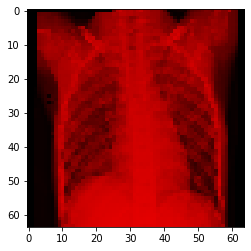

Label: 0.0


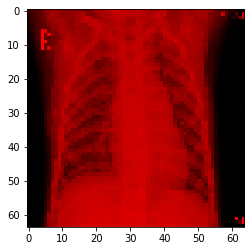

Label: 0.0


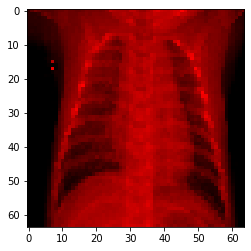

Label: 0.0


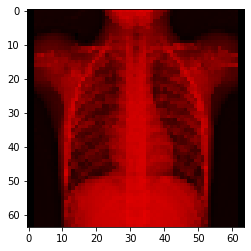

Label: 0.0


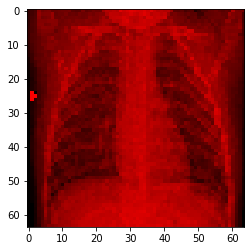

Label: 0.0


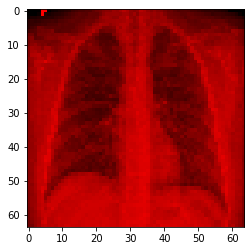

Label: 0.0


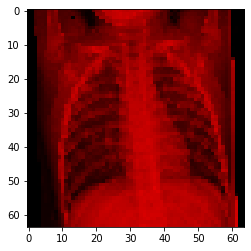

Label: 0.0


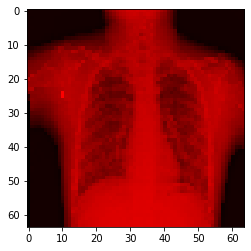

Label: 0.0


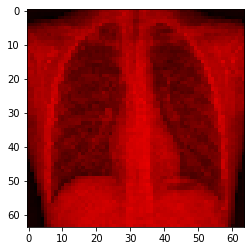

Label: 0.0


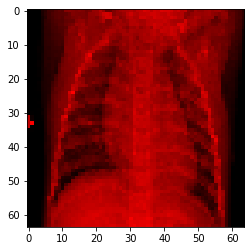

Label: 0.0


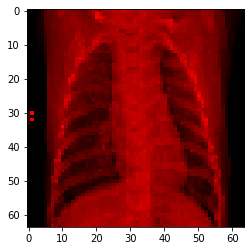

Label: 0.0


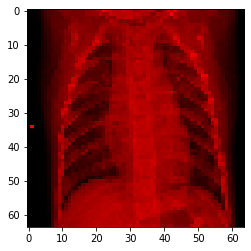

Label: 0.0


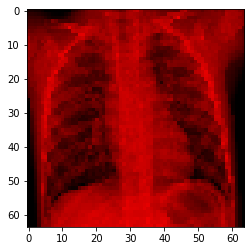

Label: 0.0


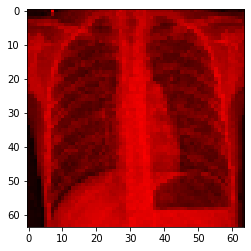

Label: 0.0


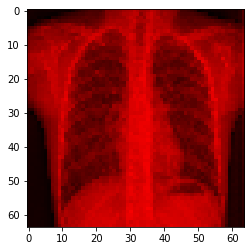

Label: 0.0


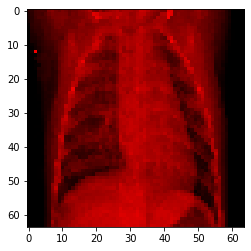

Label: 0.0


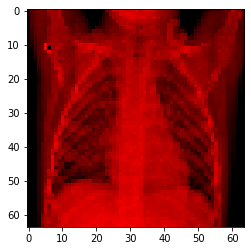

Label: 0.0


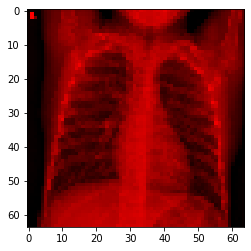

Label: 0.0


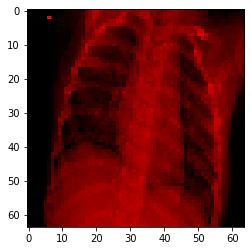

Label: 0.0


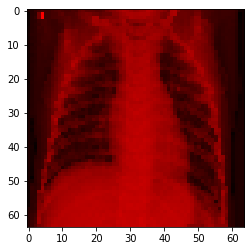

Label: 0.0


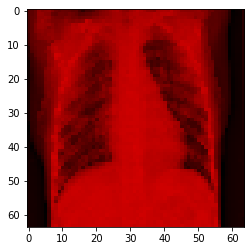

Label: 0.0


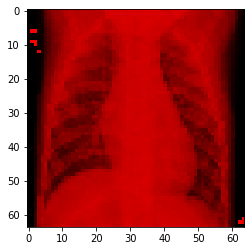

Label: 0.0


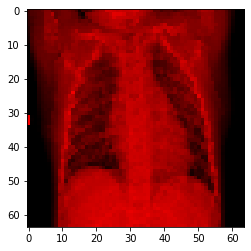

Label: 0.0


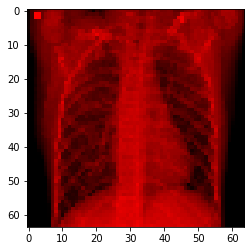

Label: 0.0


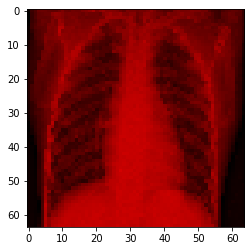

Label: 0.0


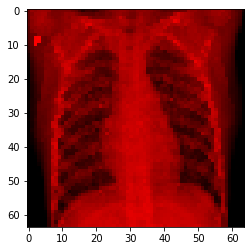

Label: 0.0


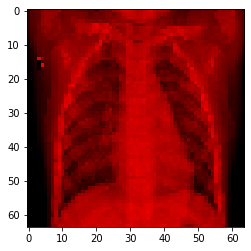

Label: 0.0


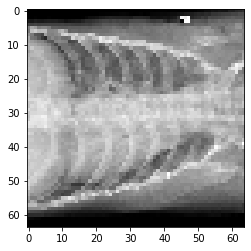

Label: 0.0


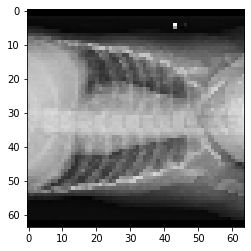

Label: 0.0


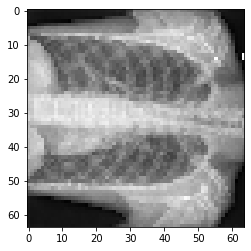

Label: 0.0


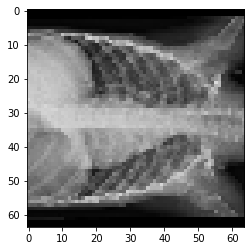

Label: 0.0


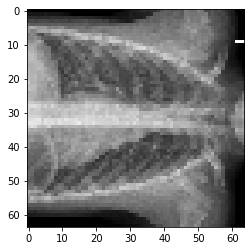

Label: 0.0


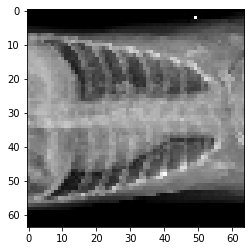

Label: 0.0


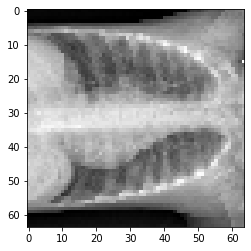

Label: 1.0


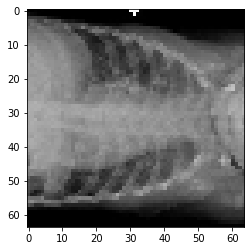

Label: 0.0


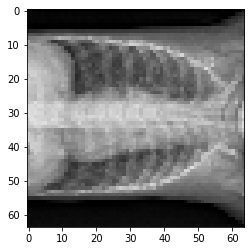

Label: 0.0


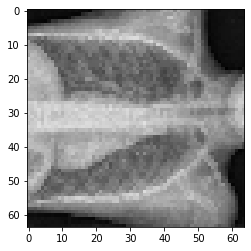

Label: 0.0


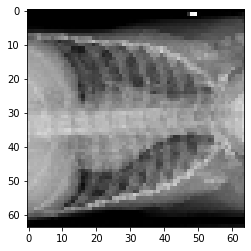

Label: 1.0


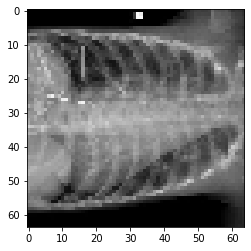

Label: 0.0


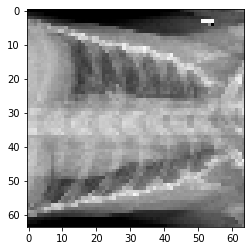

Label: 0.0


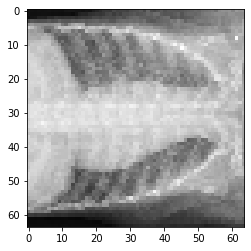

Label: 0.0


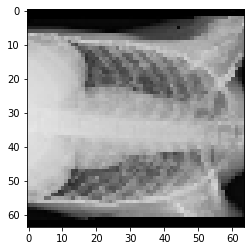

Label: 1.0


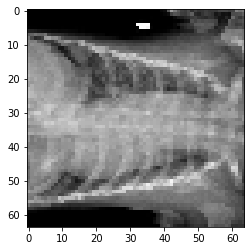

Label: 0.0


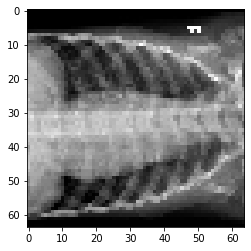

Label: 0.0


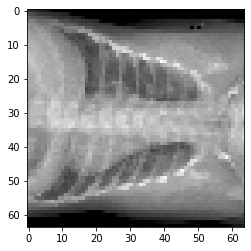

Label: 0.0


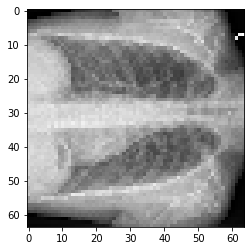

Label: 0.0


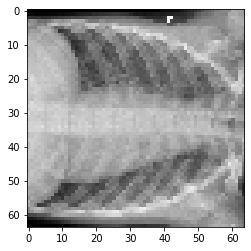

Label: 0.0


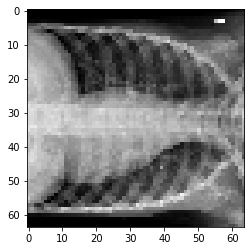

Label: 0.0


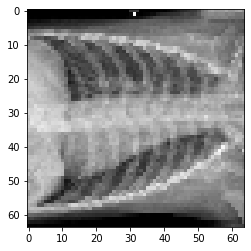

Label: 0.0


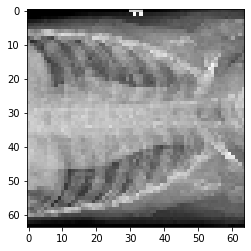

Label: 0.0


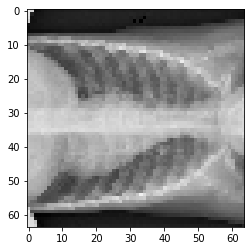

Label: 0.0


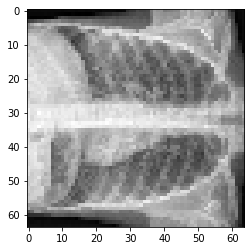

Label: 0.0


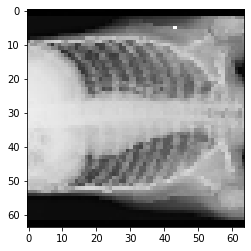

Label: 0.0


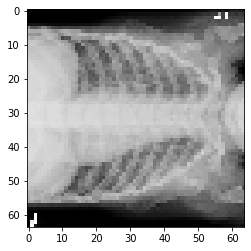

Label: 0.0


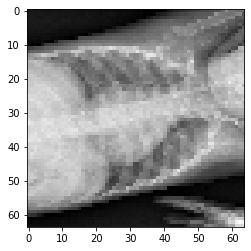

Label: 0.0


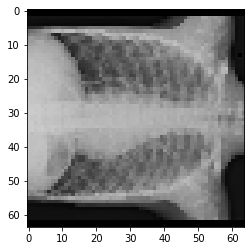

Label: 0.0


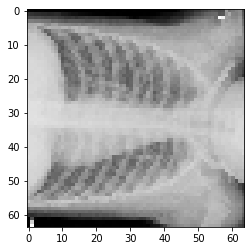

Label: 0.0


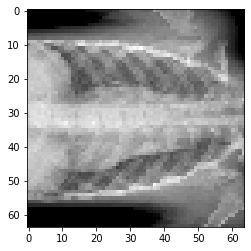

Label: 0.0


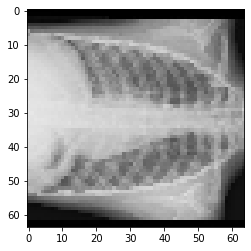

Label: 0.0


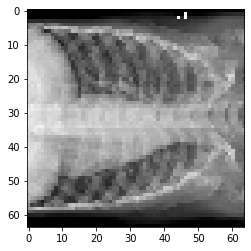

Label: 0.0


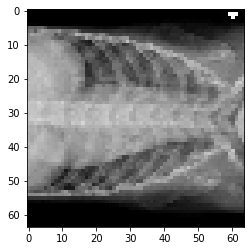

Label: 0.0


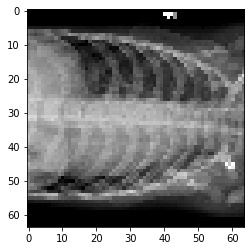

Label: 0.0


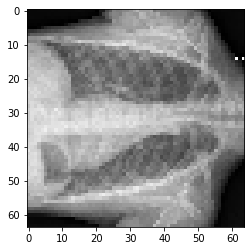

Label: 0.0


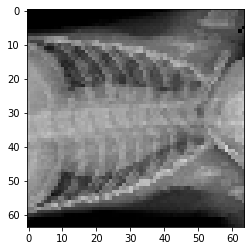

Label: 0.0


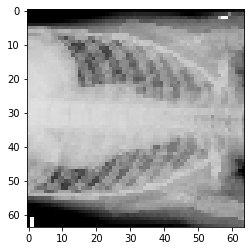

Label: 0.0


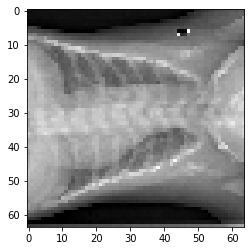

Label: 0.0


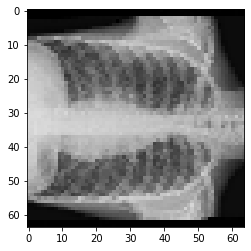

Label: 0.0


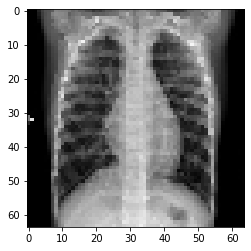

Label: 0.0


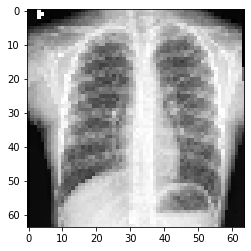

Label: 0.0


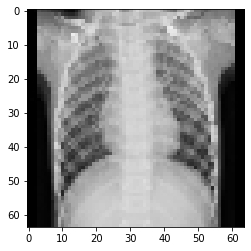

Label: 0.0


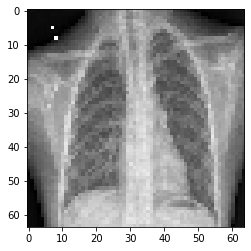

Label: 0.0


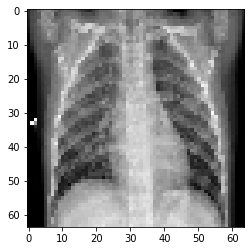

Label: 0.0


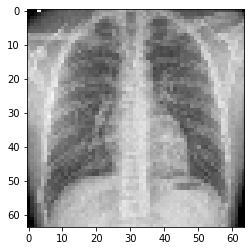

Label: 0.0


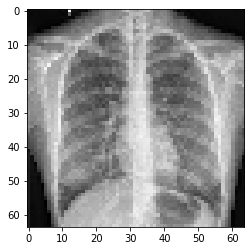

Label: 0.0


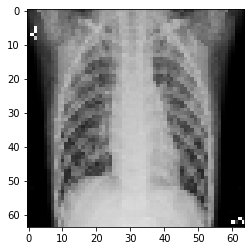

Label: 0.0


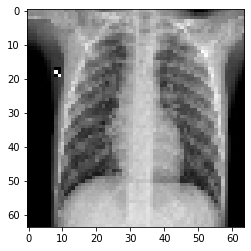

Label: 0.0


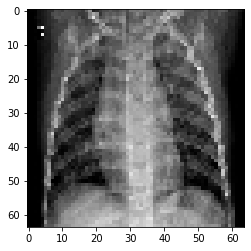

Label: 0.0


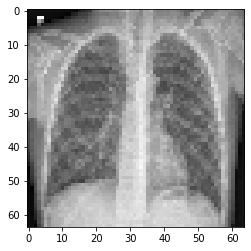

Label: 0.0


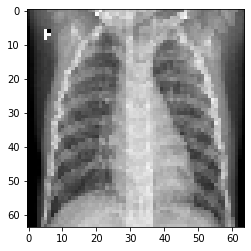

Label: 0.0


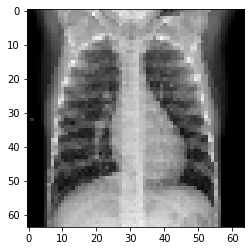

Label: 0.0


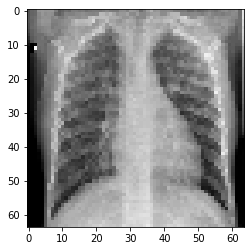

Label: 0.0


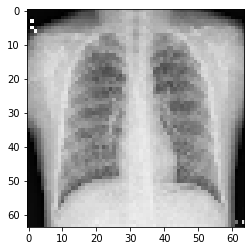

Label: 0.0


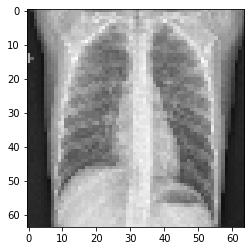

Label: 0.0


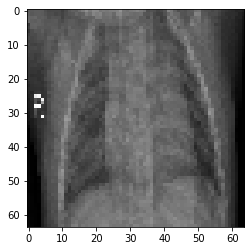

Label: 1.0


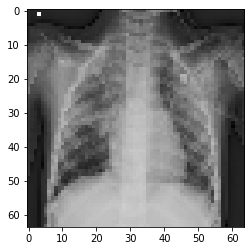

Label: 0.0


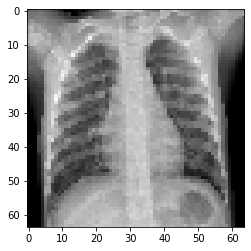

Label: 0.0


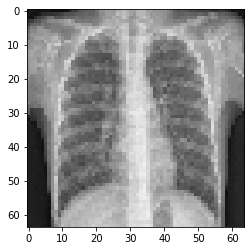

Label: 0.0


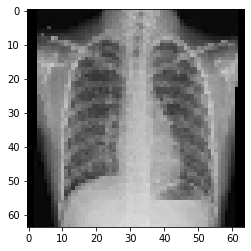

Label: 0.0


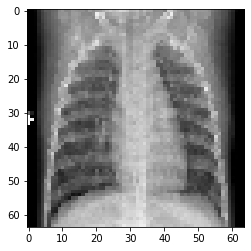

Label: 0.0


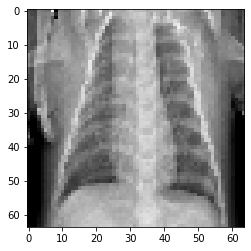

Label: 0.0


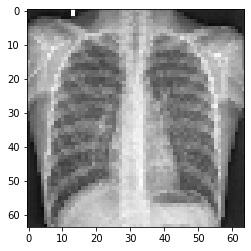

Label: 0.0


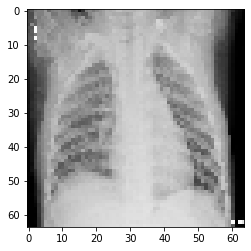

Label: 0.0


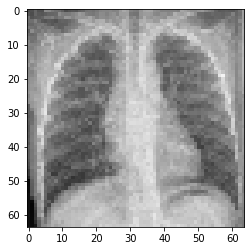

Label: 0.0


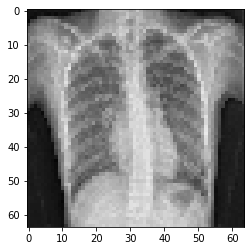

Label: 1.0


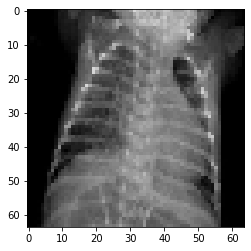

Label: 0.0


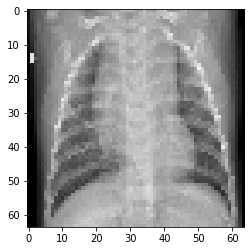

Label: 0.0


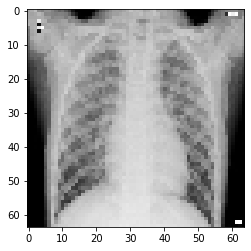

Label: 0.0


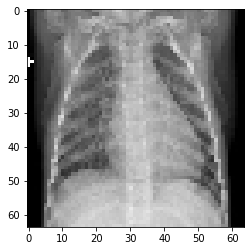

Label: 0.0


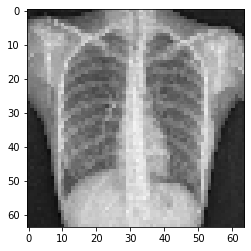

Label: 0.0


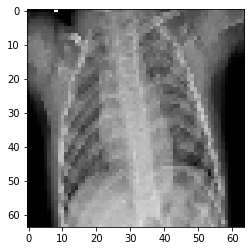

Label: 1.0


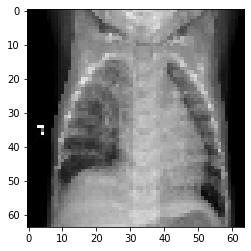

Label: 0.0


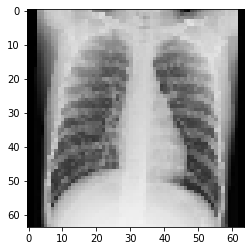

Label: 0.0


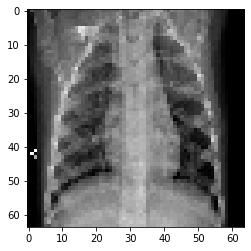

Label: 0.0


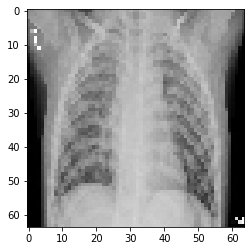

Label: 0.0


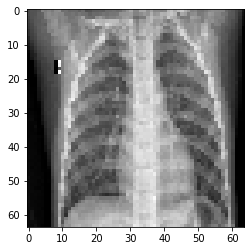

Label: 0.0


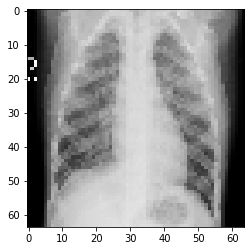

Label: 0.0


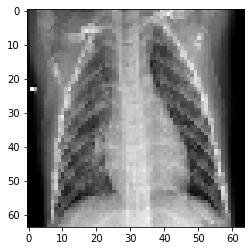

Label: 0.0


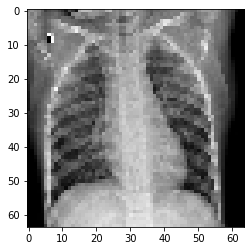

Label: 0.0


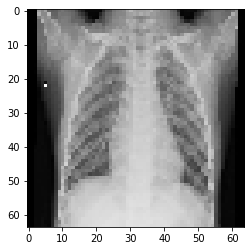

Label: 0.0


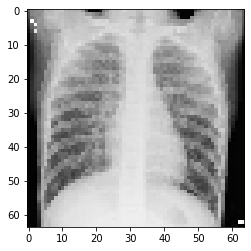

Label: 0.0


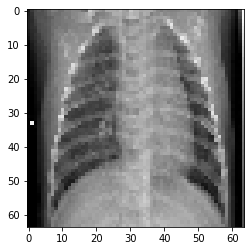

Label: 0.0


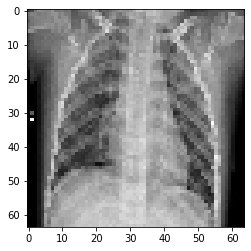

Label: 0.0


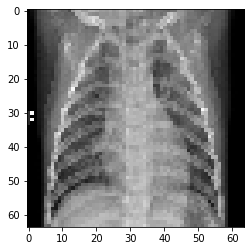

Label: 0.0


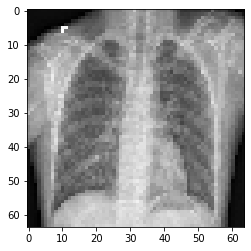

Label: 0.0


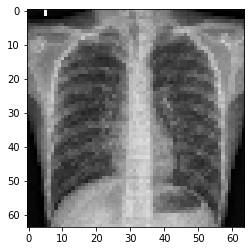

Label: 0.0


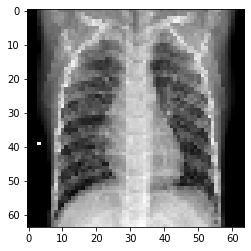

Label: 0.0


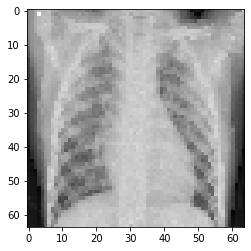

Label: 0.0


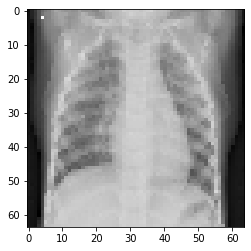

Label: 0.0


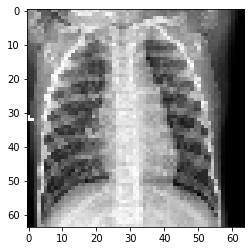

Label: 0.0


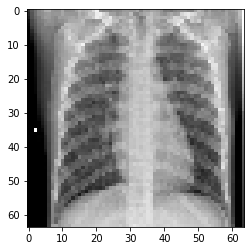

Label: 0.0


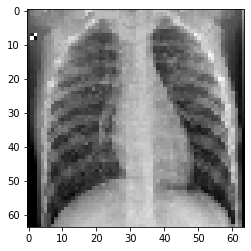

Label: 0.0


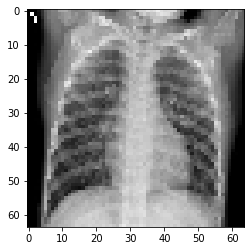

Label: 0.0


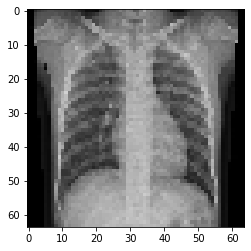

In [ ]:

[missed_data, missed_labels, predicted_labels, missed_indices] = get_misclassified_data(field_data, field_labels, predictions)
for i in range (len(missed_data)):
  plot_one_image(missed_data, missed_labels, i)


![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)